<a href="https://colab.research.google.com/github/vienskaz/COVID19-CNN/blob/main/COVID_CNN_with_padding_and_more.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import of libraries**

In [17]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd
from PIL import Image
import random
import math
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading dataset**
all images are converted to grayscale

In [2]:
data_path = "/content/drive/MyDrive/Covid19-dataset"  # Adjust this to the actual path

test_data = []
test_labels = []
train_data = []
train_labels = []

class_names = ["Covid", "Normal", "Viral Pneumonia"]

for subset in ['test', 'train']:
    subset_data = []
    subset_labels = []
    subset_path = os.path.join(data_path, subset)

    for class_name in class_names:
        class_path = os.path.join(subset_path, class_name)

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image = Image.open(image_path).convert('L')
            image = np.array(image)

            subset_data.append(image)
            subset_labels.append(class_name)

    if subset == 'test':
        test_data.extend(subset_data)
        test_labels.extend(subset_labels)
    else:
        train_data.extend(subset_data)
        train_labels.extend(subset_labels)

y_test = np.array(test_labels)
y_train = np.array(train_labels)


# **Normalization of all images to make the pixels value in range 0-1**
also all images are rezised to 400x400 pixels
with padding

In [3]:
def normalize_with_padding(images, new_height=400, new_width=400):
    normalized = []
    for i in range(len(images)):
        image = images[i]


        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        resized_image = cv2.resize(image, (new_width - 2, new_height - 2))
        normalized_image = resized_image / 255.0

        framed_image = np.zeros((new_height, new_width, 3), dtype=np.float32)
        framed_image[1:-1, 1:-1, :] = normalized_image

        normalized.append(framed_image)

    ready_arr = np.asarray(normalized)
    return ready_arr

In [4]:
X_train=normalize_with_padding(train_data)
X_test=normalize_with_padding(test_data)
X_train=tf.image.rgb_to_grayscale(X_train)
X_test=tf.image.rgb_to_grayscale(X_test)

In [5]:
def data_augmentation(images, labels):
    more_images = []
    more_labels = []

    for idx, image in enumerate(images):
        for _ in range(6):
            augmented_image = image.numpy().copy()

            rotation_angle = np.random.randint(0, 360)
            augmented_image = np.rot90(augmented_image, k=rotation_angle // 90)

            if np.random.choice([True, False]):
                augmented_image = np.flipud(augmented_image)

            brightness_factor = np.random.uniform(-0.3, 0.3)
            augmented_image = tf.image.adjust_brightness(augmented_image, brightness_factor)
            augmented_image = tf.clip_by_value(augmented_image, 0.0, 1.0)

            more_images.append(augmented_image)
            more_labels.append(labels[idx])

    more_images = np.array(more_images)
    more_labels = np.array(more_labels)

    return more_images, more_labels


In [6]:
X_train,y_train=data_augmentation(X_train,y_train)

In [7]:
print(X_train.shape)

(1506, 400, 400, 1)


# **Display of the normalized and resized images from dataset**

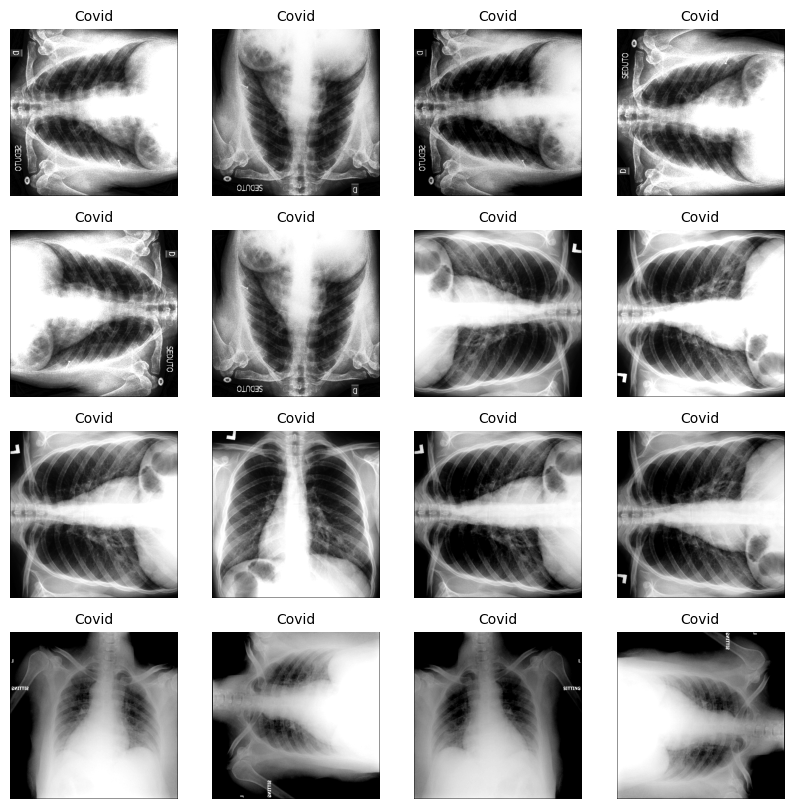

In [8]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i], fontsize=10)
    plt.axis('off')
plt.show()

# **Converting strings classes into ints**

In [9]:
class_to_index = {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
y_train_numeric = [class_to_index[label] for label in y_train]
y_train_numeric = np.array(y_train_numeric)
y_test_numeric = [class_to_index[label] for label in y_test]
y_test_numeric = np.array(y_test_numeric)


# **Model of CNN**

In [65]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu', input_shape=(400, 400,1)))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [66]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [67]:
batch_size=64
history = model.fit(X_train, y_train_numeric, epochs=50,batch_size=batch_size,shuffle=True,)
model.save("COVID")

Epoch 1/50
24/24 [==============================] - 18s 560ms/step - loss: 1.6382 - accuracy: 0.3606
Epoch 2/50
24/24 [==============================] - 12s 518ms/step - loss: 1.0521 - accuracy: 0.4502
Epoch 3/50
24/24 [==============================] - 12s 519ms/step - loss: 0.8594 - accuracy: 0.6295
Epoch 4/50
24/24 [==============================] - 13s 521ms/step - loss: 0.7083 - accuracy: 0.7271
Epoch 5/50
24/24 [==============================] - 13s 523ms/step - loss: 0.5646 - accuracy: 0.7736
Epoch 6/50
24/24 [==============================] - 12s 518ms/step - loss: 0.4592 - accuracy: 0.8234
Epoch 7/50
24/24 [==============================] - 12s 514ms/step - loss: 0.4080 - accuracy: 0.8453
Epoch 8/50
24/24 [==============================] - 12s 515ms/step - loss: 0.3789 - accuracy: 0.8599
Epoch 9/50
24/24 [==============================] - 12s 511ms/step - loss: 0.4063 - accuracy: 0.8552
Epoch 10/50
24/24 [==============================] - 12s 508ms/step - loss: 0.3506 - accura

In [68]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 398, 398, 32)      320       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 199, 199, 32)     0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 199, 199, 32)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 197, 197, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 98, 98, 64)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 98, 98, 64)       

# **Accuracy and loss plotted while training**

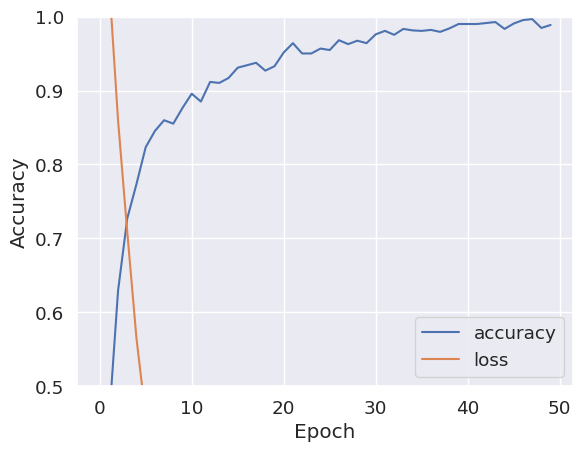

In [69]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')



In [70]:
loss, accuracy=model.evaluate(X_test,y_test_numeric)
print(f'Loss={loss}')
print(f'{accuracy * 100:.2f}%')

3/3 [==============================] - 0s 29ms/step - loss: 0.4748 - accuracy: 0.8485
Loss=0.4747745096683502
84.85%


# **Confusion matrix for test data**

3/3 [==============================] - 0s 40ms/step
tf.Tensor(
[[26  0  0]
 [ 2 18  0]
 [ 2  6 12]], shape=(3, 3), dtype=int32)


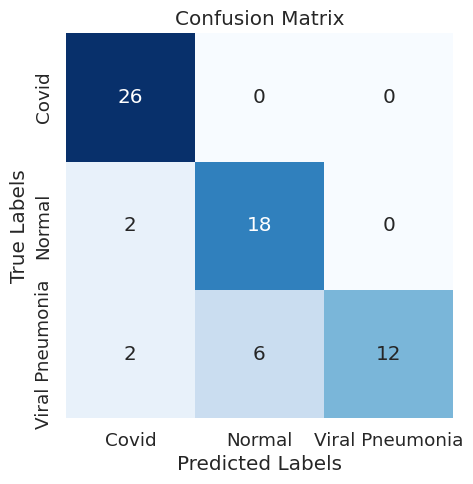

In [71]:
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)


y_test_numeric = y_test_numeric.astype(int)

confusion_matrix = tf.math.confusion_matrix(y_test_numeric, y_pred_classes)
print(confusion_matrix)


plt.figure(figsize=(5, 5))
sns.set(font_scale=1.2)

class_labels = list(class_to_index.keys())
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()


In [72]:
from sklearn.metrics import classification_report
report = classification_report(y_test_numeric, y_pred_classes, target_names=class_labels)
print(report)

                 precision    recall  f1-score   support

          Covid       0.87      1.00      0.93        26
         Normal       0.75      0.90      0.82        20
Viral Pneumonia       1.00      0.60      0.75        20

       accuracy                           0.85        66
      macro avg       0.87      0.83      0.83        66
   weighted avg       0.87      0.85      0.84        66

